In [13]:
import os

import numpy as np
import librosa

import cv2

def openAudioFile(path, sample_rate=44100, as_mono=True, mean_substract=False):
    
    # Open file with librosa (uses ffmpeg or libav)
    sig, rate = librosa.load(path, sr=sample_rate, mono=as_mono)

    # Noise reduction?
    if mean_substract:
        sig -= sig.mean()

    return sig, rate

def splitSignal(sig, rate, seconds, overlap, minlen):

    # Split signal with overlap
    sig_splits = []
    for i in range(0, len(sig), int((seconds - overlap) * rate)):
        split = sig[i:i + int(seconds * rate)]

        # End of signal?
        if len(split) < int(minlen * rate):
            break
        
        # Signal chunk too short?
        if len(split) < int(rate * seconds):
            split = np.hstack((split, np.zeros((int(rate * seconds) - len(split),))))
        
        sig_splits.append(split)

    return sig_splits

def melspec(sig, rate, shape=(128, 256), fmin=500, fmax=15000, normalize=True, preemphasis=0.95):

    # shape = (height, width) in pixels

    # Mel-Spec parameters
    SAMPLE_RATE = rate
    N_FFT = shape[0] * 8 # = window length
    N_MELS = shape[0]
    HOP_LEN = len(sig) // (shape[1] - 1)    
    FMAX = fmax
    FMIN = fmin

    # Preemphasis as in python_speech_features by James Lyons
    if preemphasis:
        sig = np.append(sig[0], sig[1:] - preemphasis * sig[:-1])

    # Librosa mel-spectrum
    melspec = librosa.feature.melspectrogram(y=sig, sr=SAMPLE_RATE, hop_length=HOP_LEN, n_fft=N_FFT, n_mels=N_MELS, fmax=FMAX, fmin=FMIN, power=1.0)
    
    # Convert power spec to dB scale (compute dB relative to peak power)
    melspec = librosa.amplitude_to_db(melspec, ref=np.max, top_db=80)

    # Flip spectrum vertically (only for better visialization, low freq. at bottom)
    melspec = melspec[::-1, ...]

    # Trim to desired shape if too large
    melspec = melspec[:shape[0], :shape[1]]

    # Normalize values between 0 and 1
    if normalize:
        melspec -= melspec.min()
        if not melspec.max() == 0:
            melspec /= melspec.max()
        else:
            mlspec = np.clip(melspec, 0, 1)

    return melspec.astype('float32')


def get_spec(sig, rate, shape, spec_type='linear', **kwargs):
    return melspec(sig, rate, shape, **kwargs)

def signal2noise(spec):

    # Get working copy
    spec = spec.copy()

    # Calculate median for columns and rows
    col_median = np.median(spec, axis=0, keepdims=True)
    row_median = np.median(spec, axis=1, keepdims=True)

    # Binary threshold
    spec[spec < row_median * 1.25] = 0.0
    spec[spec < col_median * 1.15] = 0.0
    spec[spec > 0] = 1.0

    # Median blur
    spec = cv2.medianBlur(spec, 3)

    # Morphology
    spec = cv2.morphologyEx(spec, cv2.MORPH_CLOSE, np.ones((3, 3), np.float32))

    # Sum of all values
    spec_sum = spec.sum()

    # Signal to noise ratio (higher is better)
    try:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1] * spec.shape[2])
    except:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1])

    return s2n

def specsFromSignal(sig, rate, shape, seconds, overlap, minlen, **kwargs):

    # Split signal in consecutive chunks with overlap
    sig_splits = splitSignal(sig, rate, seconds, overlap, minlen)

    # Extract specs for every sig split
    for sig in sig_splits:

        # Get spec for signal chunk
        spec = get_spec(sig, rate, shape, **kwargs)

        yield spec

def specsFromFile(path, rate, seconds, overlap, minlen, shape, start=-1, end=-1, **kwargs):

    # Open file
    sig, rate = openAudioFile(path, rate)

    # Trim signal?
    if start > -1 and end > -1:
        sig = sig[int(start * rate):int(end * rate)]
        minlen = 0

    # Yield all specs for file
    for spec in specsFromSignal(sig, rate, shape, seconds, overlap, minlen, **kwargs):
        yield spec
    
if __name__ == '__main__':

    
    for spec in specsFromFile('./data/birdclef-2021/train_short_audio/acafly/XC6671.ogg',
                              rate=32000,
                              seconds=2,
                              overlap=1,
                              minlen=1,
                              shape=(128, 256),
                              fmin=500,
                              fmax=22500,
                              spec_type='melspec'):

        # Calculate and show noise measure
        noise = signal2noise(spec)
        print(noise)

        # Show spec and wait for enter key
        cv2.imshow('SPEC', spec)
        cv2.waitKey(-1)

0.05712890625
0.0496826171875
0.04730224609375
0.044830322265625
0.05096435546875
0.044036865234375
0.0457763671875
0.00799560546875
0.046783447265625
0.05291748046875
0.06414794921875
0.07196044921875
0.0491943359375
0.011199951171875
0.04388427734375
0.057708740234375
0.04132080078125
0.0430908203125


KeyboardInterrupt: 

In [ ]:
cv2.destroyAllWindows()

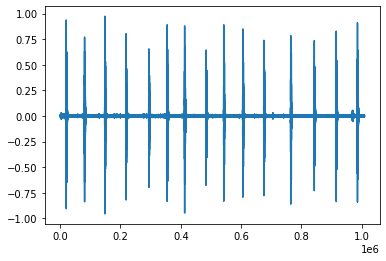

In [7]:
from matplotlib import pyplot as plt
audio_path = './data/birdclef-2021/train_short_audio/acafly/XC6671.ogg'
sig, rate = librosa.load(audio_path, sr=None, offset=None, duration=None)
plt.plot(sig)

In [17]:
a = np.array([[[1,2], [1,2]],[[1,2],[1,2]]])

In [20]:
print(a)
print(a.shape)
a.shape[3]

[[[1 2]
  [1 2]]

 [[1 2]
  [1 2]]]
(2, 2, 2)


IndexError: tuple index out of range